# Create Evidence tables

Create tables sumarizing evidence for model components.
## Setup
### Import packages

In [1]:
import requests
import pandas as pd

import matplotlib.pyplot as plt

from rbc_gem_utils import (
    COBRA_CONFIGURATION,
    ROOT_PATH,
    EXTERNAL_PATH,
    INTERIM_PATH,
    ANNOTATION_PATH,
    CURATION_PATH,
    compare_tables,
    visualize_comparison,
    get_annotation_df,
    show_versions,
    read_rbc_model,
    split_string,
    build_string,
)

# Display versions of last time notebook ran and worked
show_versions()


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
model = read_rbc_model(filetype="xml")
model.reactions.sort()
model.genes.sort()
model.metabolites.sort()
model

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-28


Name,RBC_GEM
Memory address,1522f0250
Number of metabolites,2057
Number of reactions,3030
Number of genes,779
Number of groups,78
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Load omic evidence
### Proteomic evidence

In [3]:
df_proteomic_evidence = pd.read_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv",
    sep="\t",
    index_col=0,
)
df_proteomic_evidence = pd.concat(
    (
        df_proteomic_evidence.sum(axis=1),
        pd.DataFrame.from_dict(
            {
                uniprot_id: build_string(
                    sorted(
                        [
                            f"{pubmed}"
                            for pubmed, is_detected in value_dict.items()
                            if bool(is_detected)
                        ]
                    )
                )
                for uniprot_id, value_dict in df_proteomic_evidence.T.to_dict().items()
            },
            orient="index",
        ),
    ),
    axis=1,
)
df_proteomic_evidence.columns = [
    "proteomic evidence (#studies)",
    "proteomic evidence (pubmed)",
]
df_proteomic_evidence

,proteomic evidence (#studies),proteomic evidence (pubmed)
P04406,26,pubmed:12362340;pubmed:14963112;pubmed:1686133...
P04040,25,pubmed:12362340;pubmed:14963112;pubmed:1686133...
P11142,24,pubmed:12362340;pubmed:14963112;pubmed:1686133...
P27105,23,pubmed:12362340;pubmed:14963112;pubmed:1686133...
P05089,23,pubmed:12362340;pubmed:14963112;pubmed:1686133...
...,...,...
P57738,1,pubmed:28689405
Q92536,1,pubmed:31552303
P58876,1,pubmed:33103907
P60033,1,pubmed:38260479


### Create evidence tables

In [4]:
compare = True
overwrite = True
compare_figsize = (5, 5)

#### Metabolites

,metabolites,name,formula,charge,compartment,metabolomic evidence (#studies),metabolomic evidence (pubmed),references,notes
0,10fthf_c,10-formyl-tetrahydrofolate,C20H21N7O7,-2,c,<NA>,<NA>,<NA>,<NA>
1,12ppd__R_c,"(R)-propane-1,2-diol",C3H8O2,0,c,<NA>,<NA>,<NA>,<NA>
2,12ppd__S_c,"(S)-propane-1,2-diol",C3H8O2,0,c,<NA>,<NA>,<NA>,<NA>
3,13dampp_c,"1,3-diaminopropane",C3H12N2,2,c,<NA>,<NA>,<NA>,<NA>
4,13dpg_c,3-Phospho-D-glyceroyl phosphate,C3H4O10P2,-4,c,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
2052,zn2_c,Zinc (II),Zn,2,c,<NA>,<NA>,<NA>,<NA>
2053,zn2_e,Zinc (II),Zn,2,e,<NA>,<NA>,<NA>,<NA>
2054,ztp_c,5-amino-4-imidazolecarboxamide riboside 5'-tri...,C9H13N4O14P3,-4,c,<NA>,<NA>,<NA>,<NA>
2055,zymst_c,zymosterol,C27H44O,0,c,<NA>,<NA>,<NA>,<NA>


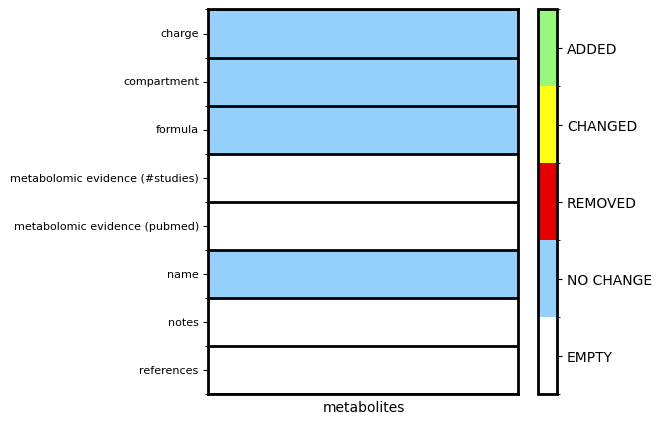

In [5]:
attribute_type = "metabolites"
try:
    df_previous = pd.read_csv(
        f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index_col=None,
    )
    df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
except FileNotFoundError:
    df_previous = pd.DataFrame([], columns=[attribute_type])

df_evidence = pd.DataFrame.from_dict(
    {
        idx: {
            f"{attribute_type}": metabolite.id,
            "name": metabolite.name,
            "formula": metabolite.formula,
            "charge": metabolite.charge,
            "compartment": metabolite.compartment,
            "metabolomic evidence (#studies)": "",  # TODO
            "metabolomic evidence (pubmed)": "",  # TODO
        }
        for idx, metabolite in enumerate(model.metabolites)
    },
    orient="index",
)
df_evidence = df_evidence.set_index(attribute_type)
df_evidence["references"] = df_previous.set_index(attribute_type)["references"]
df_evidence["references"] = (
    df_evidence["references"]
    .fillna("")
    .apply(lambda x: build_string(sorted(split_string(x))))
)
df_evidence["notes"] = df_previous.set_index(attribute_type)["notes"]
df_evidence = df_evidence.reset_index(drop=False).sort_values(
    by=["metabolomic evidence (#studies)", attribute_type, "compartment"],
    ascending=[False, True, True],
)
df_evidence = df_evidence.reset_index(drop=True)
df_evidence = df_evidence.replace(float("nan"), pd.NA).replace("", pd.NA)
df_references = df_evidence[[attribute_type, "references"]].copy()

if compare:
    compare_on_index = [attribute_type]
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index), df_evidence.set_index(compare_on_index)
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_evidence.to_csv(
        f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        f"{ROOT_PATH}{ANNOTATION_PATH}/{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )
else:
    df_evidence.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )
df_evidence

#### Genes

,genes,uniprot,ncbigene,hgnc.symbol,proteomic evidence (#studies),proteomic evidence (pubmed),references,notes
0,GAPDH,P04406,2597,GAPDH,26,pubmed:12362340;pubmed:14963112;pubmed:1686133...,pubmed:19430704,<NA>
1,CAT,P04040,847,CAT,25,pubmed:12362340;pubmed:14963112;pubmed:1686133...,pubmed:16748387;pubmed:901548,<NA>
2,HSPA8,P11142,3312,HSPA8,24,pubmed:12362340;pubmed:14963112;pubmed:1686133...,pubmed:33832207,<NA>
3,ARG1,P05089,383,ARG1,23,pubmed:12362340;pubmed:14963112;pubmed:1686133...,pubmed:13689647;pubmed:2085183;pubmed:5450162,<NA>
4,CA1,P00915,759,CA1,23,pubmed:14963112;pubmed:16861337;pubmed:1849451...,pubmed:10090333;pubmed:4958988;pubmed:4975695,<NA>
...,...,...,...,...,...,...,...,...
774,SLC9B2,Q86UD5,133308,SLC9B2,0,<NA>,pubmed:18000046;pubmed:18508966,<NA>
775,SMPD1,P17405,6609,SMPD1,0,<NA>,pubmed:25075126,<NA>
776,SMPD3,Q9NY59,55512,SMPD3,0,<NA>,pubmed:22824271;pubmed:25075126,<NA>
777,TRPC6,Q9Y210,7225,TRPC6,0,<NA>,pubmed:18209485,<NA>


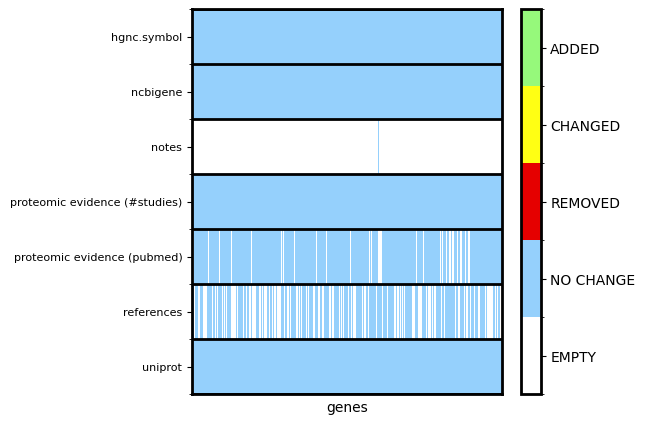

In [6]:
attribute_type = "genes"
try:
    df_previous = pd.read_csv(
        f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index_col=None,
    )
    df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
except FileNotFoundError:
    df_previous = pd.DataFrame([], columns=[attribute_type])

annotation_cols = ["uniprot", "ncbigene", "hgnc.symbol"]
df_evidence = get_annotation_df(getattr(model, attribute_type), annotation_cols)
df_evidence = df_evidence.rename({"id": attribute_type}, axis=1).set_index(
    attribute_type
)
df_evidence = df_evidence.merge(
    df_proteomic_evidence,
    left_on="uniprot",
    right_index=True,
    how="left",
)
df_evidence["proteomic evidence (#studies)"] = (
    df_evidence["proteomic evidence (#studies)"].fillna(0).astype(int)
)

df_evidence["references"] = df_previous.set_index(attribute_type)["references"]
df_evidence["references"] = (
    df_evidence["references"]
    .fillna("")
    .apply(lambda x: build_string(sorted(split_string(x))))
)
df_evidence["notes"] = df_previous.set_index(attribute_type)["notes"]
df_evidence = df_evidence.reset_index(drop=False).sort_values(
    by=["proteomic evidence (#studies)", attribute_type], ascending=[False, True]
)
df_evidence = df_evidence.reset_index(drop=True)
df_evidence = df_evidence.replace(float("nan"), pd.NA).replace("", pd.NA)
df_references = df_evidence[[attribute_type, "references"]].copy()

if compare:
    compare_on_index = [attribute_type]
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index), df_evidence.set_index(compare_on_index)
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_evidence.to_csv(
        f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        f"{ROOT_PATH}{ANNOTATION_PATH}/{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )
else:
    df_evidence.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )

model_proteomics_count = df_evidence.set_index("genes")[
    "proteomic evidence (#studies)"
].to_dict()
df_evidence

#### Reactions

,reactions,name,reaction,gene reaction rule,subsystem,spontaneous,proteomic evidence (#studies),references,notes
0,5FLUDPK,Nucleoside-diphosphate kinase (ATP:5-fluorouri...,5fludp_c + atp_c <=> 5flutp_c + adp_c,NME1 or (NME1 and NME2) or NME2 or (NME1 and N...,5-fluorouracil metabolism,0.0,NME1(18);NME2(12);NME3(1),<NA>,<NA>
1,5FLUMPK,Uridylate kinase (ATP:5-fluorouridine 5-monoph...,5flump_c + atp_c <=> 5fludp_c + adp_c,CMPK1,5-fluorouracil metabolism,0.0,CMPK1(11),<NA>,<NA>
2,5FLURAPT,5-fluorouracil phosphoribosyltransferase,5flura_c + prpp_c <=> 5flump_c + ppi_c,UMPS,5-fluorouracil metabolism,0.0,UMPS(7),<NA>,<NA>
3,D5FURADy,"5,6-dihydro-5-fluorouracil:NADP+ 5-oxidoreductase",5flura_c + h_c + nadph_c --> 56dh5flura_c + na...,DPYD,5-fluorouracil metabolism,0.0,DPYD(1),<NA>,<NA>
4,FACOAE_10_0,Acyl CoA thioesterase (CoA 10:0),FAcoa_hs_10_0_c + h2o_c --> FA_hs_10_0_c + coa...,ACOT7,Acyl-CoA hydrolysis,0.0,ACOT7(13),pubmed:10578051;pubmed:5042454,<NA>
...,...,...,...,...,...,...,...,...,...
2596,PYDXPP,Pyridoxal 5-phosphate phosphatase,h2o_c + pydx5p_c --> pi_c + pydx_c,PDXP,Vitamin B6 metabolism,0.0,PDXP(18),pubmed:1322411;pubmed:14522954;pubmed:7448195;...,<NA>
2597,AVITE1RASCBR1,Reduction of alpha-tocopherol radical via L-as...,ascb__L_c + avite1r_c <=> avite1_c + mdhdascb_...,<NA>,Vitamin E metabolism,1.0,<NA>,pubmed:18243141;pubmed:36643550;pubmed:8388377...,<NA>
2598,AVITE1RCYTB5R,Reduction of alpha-tocopherol radical via L-as...,avite1r_c + focytb5_c + h_c --> avite1_c + fic...,CYB5R3 or (CYB5R3 and CYB5B) or (CYB5R3 and CY...,Vitamin E metabolism,0.0,CYB5A(10);CYB5B(9);CYB5R3(21),pubmed:8388377,<NA>
2599,AVITE1RQ10H2R,Reduction of alpha-tocopherol radical via ubiq...,avite1r_c + q10h2_c --> avite1_c + q10h_c,<NA>,Vitamin E metabolism,1.0,<NA>,pubmed:8388377;pubmed:8434935,<NA>


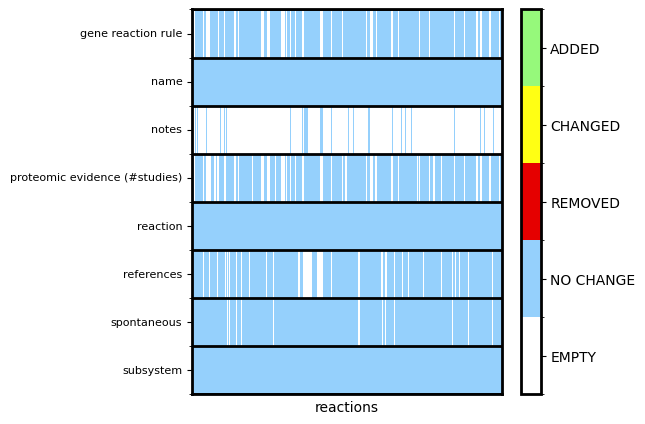

In [7]:
attribute_type = "reactions"
try:
    df_previous = pd.read_csv(
        f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index_col=None,
    )
    df_previous = df_previous.replace(float("nan"), pd.NA).replace("", pd.NA)
except FileNotFoundError:
    df_previous = pd.DataFrame([], columns=[attribute_type])

df_evidence = pd.DataFrame.from_dict(
    {
        idx: {
            f"{attribute_type}": reaction.id,
            "name": reaction.name,
            "reaction": reaction.reaction,
            "gene reaction rule": reaction.gene_reaction_rule,
            "subsystem": reaction.subsystem,
            "spontaneous": reaction.annotation.get("spontaneous", 0),
            "proteomic evidence (#studies)": build_string(
                sorted(
                    [
                        "{}({})".format(gene.id, model_proteomics_count[gene.id])
                        for gene in list(reaction.genes)
                        if model_proteomics_count[gene.id] != 0
                    ]
                )
            ),
        }
        for idx, reaction in enumerate(
            model.reactions.query(lambda x: not x.subsystem in {"Pseudoreactions"})
        )
    },
    orient="index",
)
df_evidence = df_evidence.set_index(attribute_type)
# Preserve reactions marked spontaneous based on reference data
df_evidence["spontaneous"] = df_previous.set_index(attribute_type)["spontaneous"]
df_evidence["references"] = df_previous.set_index(attribute_type)["references"]
df_evidence["references"] = (
    df_evidence["references"]
    .fillna("")
    .apply(lambda x: build_string(sorted(split_string(x))))
)
df_evidence["notes"] = df_previous.set_index(attribute_type)["notes"]
df_evidence = df_evidence.reset_index(drop=False).sort_values(
    by=["subsystem", "reactions"], ascending=[True, True]
)
df_evidence = df_evidence.reset_index(drop=True)
df_evidence = df_evidence.replace(float("nan"), pd.NA).replace("", pd.NA)
df_references = df_evidence[[attribute_type, "references"]].copy()

if compare:
    compare_on_index = [attribute_type]
    df_comparision = compare_tables(
        df_previous.set_index(compare_on_index), df_evidence.set_index(compare_on_index)
    )

    fig, ax = plt.subplots(1, 1, figsize=compare_figsize)
    ax.yaxis.set_tick_params(labelsize=8)
    ax = visualize_comparison(df_comparision)


if overwrite:
    df_evidence.to_csv(
        f"{ROOT_PATH}{CURATION_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        f"{ROOT_PATH}{ANNOTATION_PATH}/{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )
else:
    df_evidence.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{attribute_type}_evidence.tsv",
        sep="\t",
        index=False,
    )
    df_references.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/{attribute_type}_References.tsv",
        sep="\t",
        index=False,
    )
df_evidence

In [8]:
set1 = set(
    df_evidence[df_evidence["references"].isna()].loc[:, attribute_type].unique()
)
set2 = set(
    df_evidence[df_evidence["references"].notna()].loc[:, attribute_type].unique()
)
set3 = set(
    df_evidence[df_evidence["proteomic evidence (#studies)"].isna()]
    .loc[:, attribute_type]
    .unique()
)
set4 = set(
    df_evidence[df_evidence["proteomic evidence (#studies)"].notna()]
    .loc[:, attribute_type]
    .unique()
)
set5 = set(df_evidence[df_evidence["spontaneous"] == 1].loc[:, attribute_type].unique())
assert len(df_evidence) == len(set1.union(set2).union(set3).union(set4).union(set5))
print(f"Known spontaneous: {len(set1.intersection(set3).intersection(set5))}")
print(f"No clear evidence: {len(set1.intersection(set3).difference(set5))}")
print(f"Only omic evidence: {len(set1.intersection(set4))}")
print(f"Only lit. evidence: {len(set2.intersection(set3))}")
print(f"Both evidence types: {len(set2.intersection(set4))}")
print(f"Total {attribute_type}: {len(df_evidence)}")

Known spontaneous: 4
No clear evidence: 77
Only omic evidence: 319
Only lit. evidence: 530
Both evidence types: 1671
Total reactions: 2601
